### Import packages for data extraction and exploratory analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf
!pip install fredapi
from fredapi import Fred

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import aic, bic


### Data Extraction

In [2]:
#S&P 500 (stock prices)
sp500 = yf.download("^GSPC",start="2000-01-01")[["Close"]]
sp500 = sp500.rename(columns={"Close": "SP500"})

# 3-month T-Bill (^IRX on Yahoo gives yield in %)
t3m = yf.download("^IRX", start="2000-01-01")[["Close"]]
t3m = t3m.rename(columns={"Close": "TBILL_3M"})

# 10-year Treasury yield (^TNX also in %)
t10y = yf.download("^TNX", start="2000-01-01")[["Close"]]
t10y = t10y.rename(columns={"Close": "YIELD_10Y"})

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Basic Data Inspection

In [3]:
print(sp500.head(), t3m.head(), t10y.head())
print(sp500.tail(), t3m.tail(), t10y.tail())
#print(sp500.describe(), t3m.describe(), t10y.describe())

Price             SP500
Ticker            ^GSPC
Date                   
2000-01-03  1455.219971
2000-01-04  1399.420044
2000-01-05  1402.109985
2000-01-06  1403.449951
2000-01-07  1441.469971 Price      TBILL_3M
Ticker         ^IRX
Date               
2000-01-03     5.27
2000-01-04     5.27
2000-01-05     5.27
2000-01-06     5.24
2000-01-07     5.22 Price      YIELD_10Y
Ticker          ^TNX
Date                
2000-01-03     6.548
2000-01-04     6.485
2000-01-05     6.599
2000-01-06     6.549
2000-01-07     6.504
Price             SP500
Ticker            ^GSPC
Date                   
2025-10-16  6629.069824
2025-10-17  6664.009766
2025-10-20  6735.129883
2025-10-21  6735.350098
2025-10-22  6700.250000 Price      TBILL_3M
Ticker         ^IRX
Date               
2025-10-16    3.853
2025-10-17    3.832
2025-10-20    3.798
2025-10-21    3.785
2025-10-22    3.788 Price      YIELD_10Y
Ticker          ^TNX
Date                
2025-10-16     3.976
2025-10-17     4.007
2025-10-20     3.986
20

### Resample to weekly frequence, Merge DF, Drop NaNs and Describing

In [4]:
sp500_w = sp500.resample(FREQ).last()
t3m_w   = t3m.resample(FREQ).last()
t10y_w  = t10y.resample(FREQ).last()

data = sp500_w.join([t3m_w, t10y_w], how="inner").dropna()
data.columns = ["S&P500", "YIELD_3M", "YIELD_10Y"]

print(data.describe())
print(data.corr())

#data.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/raw_dataset.csv")

            S&P500     YIELD_3M    YIELD_10Y
count  1347.000000  1347.000000  1347.000000
mean   2238.777543     1.856743     3.306480
std    1410.668725     1.929475     1.294278
min     683.380005    -0.058000     0.536000
25%    1212.595032     0.090000     2.220500
50%    1519.790039     1.177000     3.395000
75%    2873.105103     3.595000     4.285500
max    6715.790039     6.190000     6.781000
             S&P500  YIELD_3M  YIELD_10Y
S&P500     1.000000  0.282831  -0.180659
YIELD_3M   0.282831  1.000000   0.749488
YIELD_10Y -0.180659  0.749488   1.000000


### Data Visualization

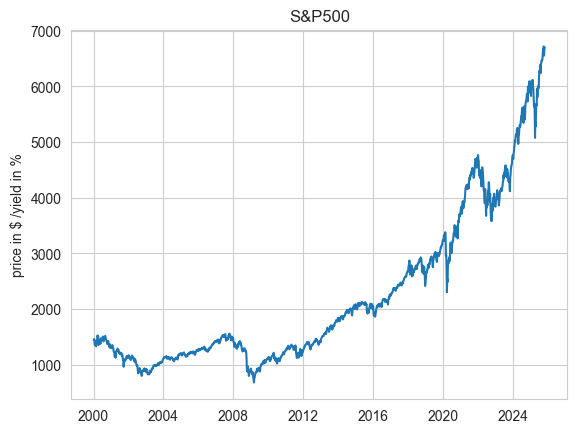

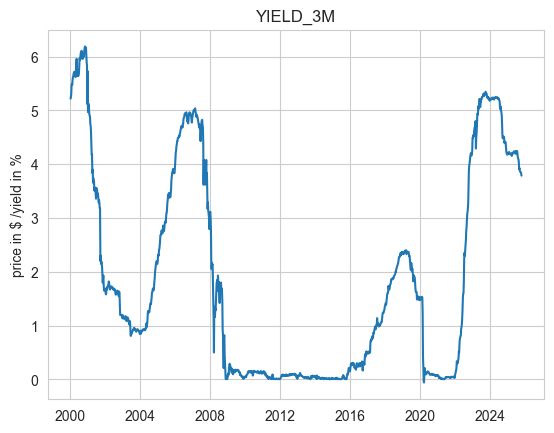

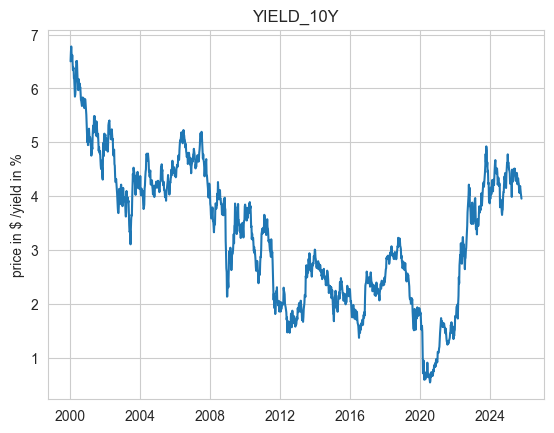

<Axes: >

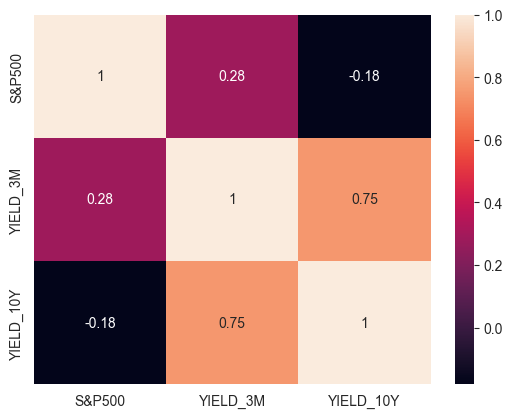

In [5]:
for column in data.columns:
    plt.plot(data[column], label=column)
    plt.title(column)
    plt.ylabel('price in $ /yield in %')
    plt.show()

sns.heatmap(data.corr(), annot=True)

### Data transformation (Log diffs)

In [7]:
data["spy_rt"] = np.log(data["S&P500"]).diff().dropna()
data["d_tbill"] = data["YIELD_3M"].diff().dropna()     # Δ i_t short-term
data["d_tbond"] = data["YIELD_10Y"].diff().dropna() # Δ i_t long-term

data_chg = data[["spy_rt", "d_tbill", "d_tbond"]]
#data_chg.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/data_chg.csv")

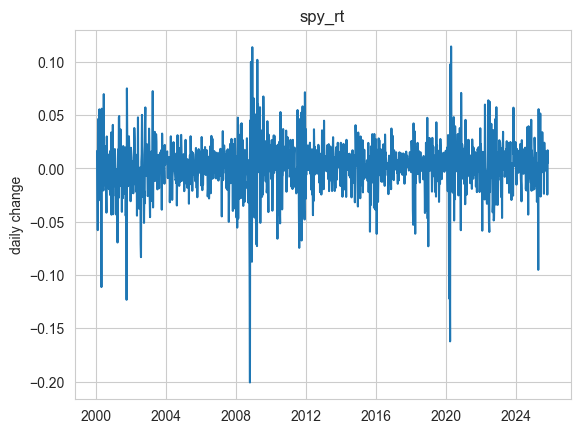

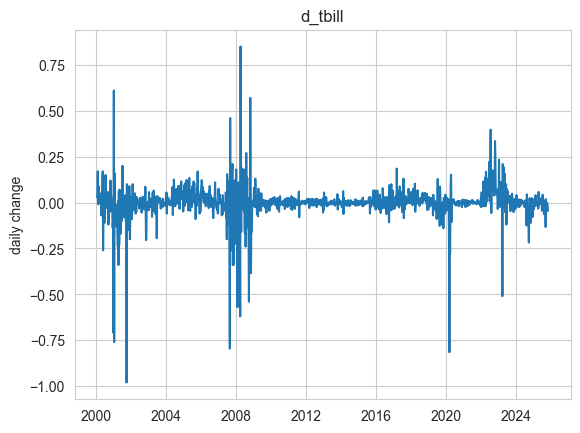

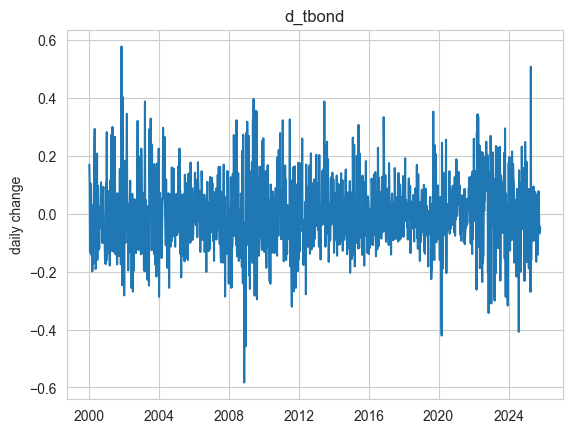

In [8]:
for column in data_chg.columns:
    plt.plot(data_chg[column], label=column, color=sns.color_palette()[0])
    plt.title(column)
    plt.ylabel('daily change')
    plt.show()

## Step 2: Testing for Stationarity (ADF)

In this step, we formally test whether our three transformed series are **stationary** — a key requirement before moving on to ARMA, GARCH, or VAR modeling.

The **Augmented Dickey–Fuller (ADF) test** is used to check for the presence of a **unit root** in each time series.

$$
H_0: \text{Series has a unit root (non-stationary)} \
$$
H_1: \text{Series is stationary (I(0))}
$$

We apply the test to the following variables:

* ( $r_t$ = $\Delta$ $\log(P_t)$ ): S&P 500 log returns
* ( $\Delta$ $i_t^{(3M)}$ ): weekly change in the 3-month T-bill yield
* ( $\Delta$ $i_t^{(10Y)}$ ): weekly change in the 10-year bond yield

If the **p-value < 0.05**, we reject $H_0$ and conclude that the series is **stationary**.

This step ensures that our transformed variables are suitable for modeling with ARMA, GARCH, and VAR frameworks in the subsequent stages.



In [9]:
# Step 2 — ADF tests for stationarity
import os
import pandas as pd
from statsmodels.tsa.stattools import adfuller

series_dict = {
    "r_t (Δ log P_t)": data_chg["spy_rt"].dropna(),
    "Δi_t (3M T-bill)": data_chg["d_tbill"].dropna(),
    "Δi_t (10Y bond)": data_chg["d_tbond"].dropna(),
}

def adf_summary(x):
    res = adfuller(x, autolag="AIC")
    stat, pval, lags, nobs, crit = res[0], res[1], res[2], res[3], res[4]
    return {
        "ADF_stat": stat,
        "p_value": pval,
        "lags_used": lags,
        "nobs": nobs,
        "cv_1%": crit.get("1%"),
        "cv_5%": crit.get("5%"),
        "cv_10%": crit.get("10%")
    }

results = pd.DataFrame({name: adf_summary(s) for name, s in series_dict.items()}).T
results = results[["ADF_stat","p_value","lags_used","nobs","cv_1%","cv_5%","cv_10%"]]


print("\nAugmented Dickey–Fuller (ADF) stationarity tests")
print("(H0: unit root; reject H0 ⇒ stationary / I(0))\n")
print(results.round(4))

#results.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/results.csv")



Augmented Dickey–Fuller (ADF) stationarity tests
(H0: unit root; reject H0 ⇒ stationary / I(0))

                  ADF_stat  p_value  lags_used    nobs   cv_1%   cv_5%  cv_10%
r_t (Δ log P_t)   -19.7427   0.0000        3.0  1342.0 -3.4352 -2.8637 -2.5679
Δi_t (3M T-bill)   -4.6711   0.0001       23.0  1322.0 -3.4353 -2.8637 -2.5679
Δi_t (10Y bond)   -16.7492   0.0000        3.0  1342.0 -3.4352 -2.8637 -2.5679


## Step 3: Modeling Short-Run Dynamics with ARMA

We now model the short-term behavior of the **S&P 500 log returns** (( r_t = \Delta \log P_t )) using an **Autoregressive Moving Average (ARMA)** model.

Formally:

$$
r_t = \mu + \sum_{i=1}^{p} \phi_i r_{t-i} + \sum_{j=1}^{q} \theta_j \varepsilon_{t-j} + \varepsilon_t
$$

where:

* ( \phi_i ) are the **autoregressive coefficients** capturing momentum or mean reversion,
* ( \theta_j ) are the **moving average coefficients** capturing shock persistence, and
* ( \varepsilon_t ) is a white-noise innovation with ( E(\varepsilon_t)=0 ) and ( Var(\varepsilon_t)=\sigma^2 ).

The orders ( (p,q) ) are identified by minimizing the **Akaike Information Criterion (AIC)**, following the same procedure used in the course notes.

Once the best ARMA specification is selected, we will later analyze its residuals to model conditional volatility using **GARCH**.


In [10]:
# Step 3 — ARMA Identification and Estimation for r_t
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

y = data_chg["spy_rt"].dropna()

# Define search grid for p and q
pq_grid = [(p, q) for p in range(0, 4) for q in range(0, 4) if not (p == 0 and q == 0)]

best_ic = np.inf
best_order = None
best_res = None

for p, q in pq_grid:
    try:
        model = ARIMA(y, order=(p, 0, q))
        res = model.fit(method_kwargs={"warn_convergence": False})
        ic = res.aic
        print(f"(p={p}, q={q})  AIC={ic:.2f}")
        if ic < best_ic:
            best_ic = ic
            best_order = (p, q)
            best_res = res
    except Exception:
        continue

print(f"\nBest ARMA order by AIC: p={best_order[0]}, q={best_order[1]} (AIC={best_ic:.2f})")
print(best_res.summary())

#best_res.summary().to_csv("/Users/eduardo/Desktop/FinancialEconometrics/best_model_summary.csv")


ARMA model selection for r_t (Δ log P_t):
(p=0, q=1)  AIC=-6126.00
(p=0, q=2)  AIC=-6127.05
(p=0, q=3)  AIC=-6129.20
(p=1, q=0)  AIC=-6126.69
(p=1, q=1)  AIC=-6127.21
(p=1, q=2)  AIC=-6125.83
(p=1, q=3)  AIC=-6128.67
(p=2, q=0)  AIC=-6127.70
(p=2, q=1)  AIC=-6124.50
(p=2, q=2)  AIC=-6123.82
(p=2, q=3)  AIC=-6127.95
(p=3, q=0)  AIC=-6128.03
(p=3, q=1)  AIC=-6126.22
(p=3, q=2)  AIC=-6128.83
(p=3, q=3)  AIC=-6126.03

Best ARMA order by AIC: p=0, q=3 (AIC=-6129.20)
                               SARIMAX Results                                
Dep. Variable:                 spy_rt   No. Observations:                 1346
Model:                 ARIMA(0, 0, 3)   Log Likelihood                3069.602
Date:                Wed, 22 Oct 2025   AIC                          -6129.205
Time:                        21:48:07   BIC                          -6103.180
Sample:                    01-14-2000   HQIC                         -6119.457
                         - 10-24-2025                       

## Step 4: Modeling Conditional Volatility with GARCH(1,1)

We now model the **time-varying volatility** of the S&P 500 returns using a **GARCH(1,1)** specification, as the residuals from the ARMA(0,3) model exhibit non-constant variance.

Formally:

$$
\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2
$$

where:

* $\alpha$: measures the short-run impact of shocks on volatility, and
* $\beta$:  captures volatility persistence.

This step captures **volatility clustering**, a key feature of financial time series, where large movements in returns tend to be followed by periods of high volatility.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 31.0 MB/s  0:00:00
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2930.89
Distribution:                  Normal   AIC:                           5867.79
Method:            Maximum Likelihood   BIC:                           5883.40
                                        No. Observations:                 1346
Date:                Wed, Oct 22 2025   Df Residuals:                     1346
Time:                        21:58:22   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
-----------------------------------------------------------------

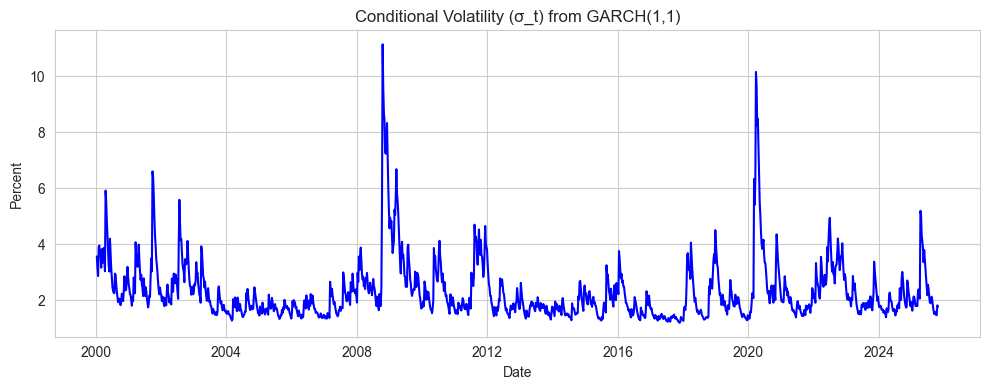

In [12]:
#!pip install arch
from arch import arch_model
import matplotlib.pyplot as plt
import os

# Residuals from best ARMA(0,3)
residuals = best_res.resid.dropna()

# Fit GARCH(1,1) on returns (mean zero specification)
am = arch_model(residuals * 100, vol='GARCH', p=1, q=1, mean='Zero')
garch_res = am.fit(disp='off')

print(garch_res.summary())

# Plot conditional volatility
plt.figure(figsize=(10, 4))
plt.plot(garch_res.conditional_volatility, color='blue')
plt.title('Conditional Volatility (σ_t) from GARCH(1,1)')
plt.ylabel('Percent')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

#garch_res.summary().to_csv("/Users/eduardo/Desktop/FinancialEconometrics/garchsummary.csv")


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -11.64     -11.64*   8.772e-06     -11.64*
1      -11.65      -11.62   8.746e-06      -11.64
2      -11.65      -11.61   8.740e-06      -11.63
3      -11.65      -11.59   8.757e-06      -11.63
4      -11.65      -11.58   8.746e-06      -11.62
5      -11.64      -11.56   8.776e-06      -11.61
6      -11.65      -11.55   8.730e-06      -11.61
7     -11.65*      -11.53  8.707e-06*      -11.61
8      -11.65      -11.52   8.726e-06      -11.60
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 22, Oct, 2025
Time:                     22:20:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.5326
Nobs:                     1339.00    

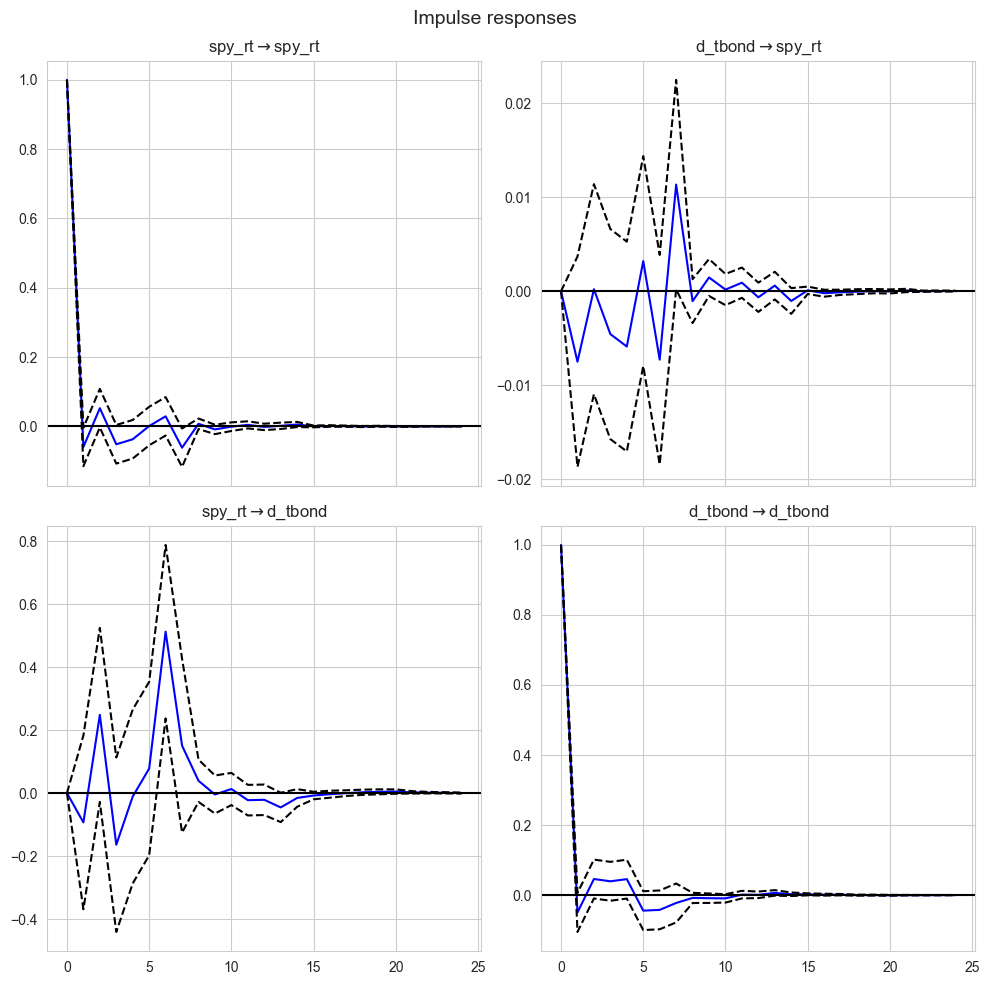


H0: Δi_t (10Y) does NOT Granger-cause r_t
Granger causality F-test. H_0: d_tbond does not Granger-cause spy_rt. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.241          2.013   0.276 (7, 2648)
-----------------------------------------------

H0: r_t does NOT Granger-cause Δi_t (10Y)
Granger causality F-test. H_0: spy_rt does not Granger-cause d_tbond. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         2.844          2.013   0.006 (7, 2648)
-----------------------------------------------


AttributeError: 'VARResults' object has no attribute 'to_csv'

In [16]:
# Step 5 — VAR between r_t and Δi_t (10Y)
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt


# Prepare data for VAR
Z = data_chg[["spy_rt", "d_tbond"]].dropna()

# Select optimal lag order
var_model = VAR(Z)
lag_selection = var_model.select_order(maxlags=8)
print(lag_selection.summary())

# Fit VAR(p) using AIC-selected lag
p_opt = lag_selection.aic
var_res = var_model.fit(p_opt)
print(var_res.summary())

# Plot Impulse Response Functions (24 weeks or 0.5 year ahead)
irf = var_res.irf(24)
irf.plot(orth=False)
plt.tight_layout()
plt.show()

# Granger causality tests
print("\nH0: Δi_t (10Y) does NOT Granger-cause r_t")
print(var_res.test_causality(caused="spy_rt", causing=["d_tbond"], kind="f").summary())

print("\nH0: r_t does NOT Granger-cause Δi_t (10Y)")
print(var_res.test_causality(caused="d_tbond", causing=["spy_rt"], kind="f").summary())

var_res.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/var_summary.csv")


In [17]:
# Step 6 — Save VAR(7) output and key statistics
import pandas as pd
import os

# Define output path
out_path = "/Users/eduardo/Desktop/FinancialEconometrics/var_summary.csv"
os.makedirs(os.path.dirname(out_path), exist_ok=True)

# Save estimated parameters
params_df = pd.DataFrame(var_res.params)
params_df.to_csv(out_path, index=True)

# Also save basic model information
stats = {
    "aic": [var_res.aic],
    "bic": [var_res.bic],
    "hqic": [getattr(var_res, "hqic", None)],
    "nobs": [var_res.nobs],
    "selected_lags": [var_res.k_ar]
}
stats_df = pd.DataFrame(stats)
stats_df.to_csv("/Users/eduardo/Desktop/FinancialEconometrics/var_model_stats.csv", index=False)

print(f"VAR parameters saved to: {out_path}")
print("Model stats saved as var_model_stats.csv")


VAR parameters saved to: /Users/eduardo/Desktop/FinancialEconometrics/var_summary.csv
Model stats saved as var_model_stats.csv


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -11.64     -11.62*   8.805e-06     -11.63*
1      -11.64      -11.60   8.776e-06      -11.63
2      -11.64      -11.59   8.773e-06      -11.62
3      -11.64      -11.57   8.791e-06      -11.62
4      -11.64      -11.56   8.781e-06      -11.61
5      -11.64      -11.54   8.810e-06      -11.60
6      -11.64      -11.53   8.763e-06      -11.60
7     -11.65*      -11.52  8.739e-06*      -11.60
8      -11.65      -11.50   8.759e-06      -11.59
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 22, Oct, 2025
Time:                     22:26:25
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.5133
Nobs:                     1339.00    

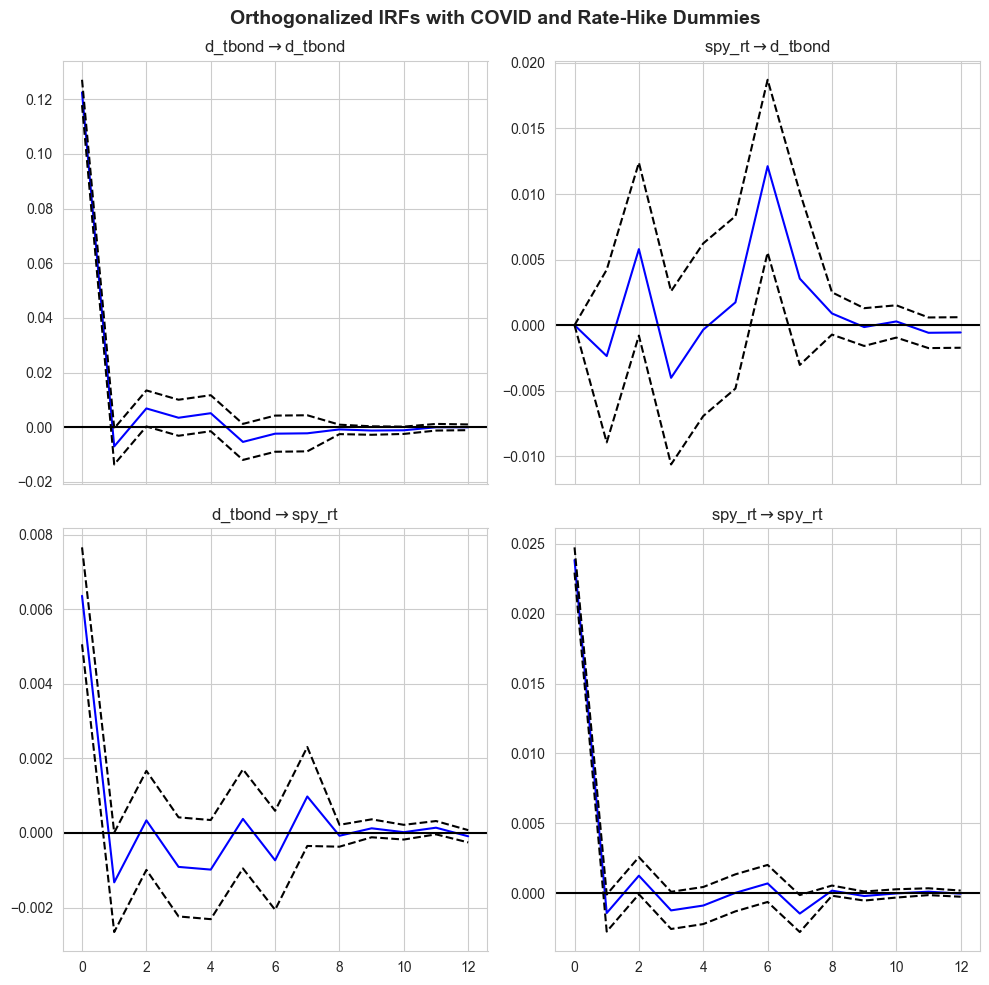

Saved orthogonalized IRFs and model parameters with exogenous dummies.


In [18]:
# Step 8 — Orthogonalized IRFs with COVID & Rate Hike Dummies
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.api import VAR

# Prepare data
Z = data_chg[["d_tbond", "spy_rt"]].dropna()  # order: rates first, returns second

# Create exogenous dummies
exog = pd.DataFrame(index=Z.index)
exog["covid"] = ((exog.index >= "2020-03-01") & (exog.index <= "2020-06-30")).astype(int)
exog["rate_hike"] = (exog.index >= "2022-03-01").astype(int)

# Fit VAR with exogenous dummies
var_ex = VAR(endog=Z, exog=exog)
lag_selection = var_ex.select_order(maxlags=8)
print(lag_selection.summary())

p_opt = lag_selection.aic
var_ex_res = var_ex.fit(p_opt)
print(var_ex_res.summary())

# Orthogonalized IRFs (Cholesky, order: rates → returns)
irf_ex = var_ex_res.irf(12)
fig = irf_ex.plot(orth=True)
plt.suptitle("Orthogonalized IRFs with COVID and Rate-Hike Dummies", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()

# Save IRF results and parameters
os.makedirs("/Users/eduardo/Desktop/FinancialEconometrics", exist_ok=True)
irf_ex_df = irf_ex.irfs.reshape(irf_ex.irfs.shape[0], -1)
cols = [f"response_{i}_{j}" for i in Z.columns for j in Z.columns]
pd.DataFrame(irf_ex_df, columns=cols).to_csv(
    "/Users/eduardo/Desktop/FinancialEconometrics/irf_exog_results.csv", index=False
)
var_ex_res.params.to_csv(
    "/Users/eduardo/Desktop/FinancialEconometrics/var_exog_params.csv"
)
print("Saved orthogonalized IRFs and model parameters with exogenous dummies.")
